# Variant effect prediction - ablation study

In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.special import softmax
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plot_dir = "../../results/plots/"

In [3]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency\n(no neural net)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50%\nmost conserved",
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include\nclosest primates",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight\nconserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace\nnon-conserved",
    r"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 256",
    r"multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 64",
    r"multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 32",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.4": "Window size = 4 (VEP time)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.8": "Window size = 8 (VEP time)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.16": "Window size = 16 (VEP time)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.32": "Window size = 32 (VEP time)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.64": "Window size = 64 (VEP time)",
}

In [4]:
models = pd.read_csv("../../models.txt", header=None).values.ravel().tolist()
model_renaming = {}
models

['multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/8

In [5]:
models += [f"{models[i]}.{window_size_ablation}" for window_size_ablation in [4, 8, 16, 32, 64] for i in range(3)]
models

['multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/8

In [6]:
dataset_path = "songlab/human_variants"
V = load_dataset(dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(models):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
V

Repo card metadata block was not found. Setting CardData to empty.
100%|██████████| 27/27 [00:04<00:00,  5.51it/s]


,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.8,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.64
0,1,14731,G,A,Rare,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,-4.949219,-3.962891,-4.222656,-4.625000,-5.539062,-4.976562,-4.851562,-5.261719,-4.855469,-5.144531
1,1,16487,T,C,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,-3.789062,-3.466797,-3.740234,-3.605469,-3.511719,-3.679688,-3.548828,-3.564453,-3.611328,-3.443359
2,1,62015,C,G,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,-3.746094,-3.503906,-3.537109,-3.921875,-3.628906,-3.464844,-3.560547,-3.705078,-3.652344,-3.607422
3,1,62046,A,T,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,-1.509766,-3.228516,-3.494141,-3.699219,-3.068359,-3.597656,-4.164062,-2.513672,-2.882812,-3.027344
4,1,64866,T,G,Rare,gnomAD,"downstream_gene_variant,upstream_gene_variant",None,None,None,...,-3.712891,-4.339844,-4.593750,-4.132812,-3.503906,-3.048828,-3.205078,-1.589844,-1.616211,-1.604492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9761262,Y,2787426,C,G,Pathogenic,ClinVar,missense_variant,9739,"criteria_provided,_single_submitter",None,...,-5.750000,-7.183594,-7.046875,-6.898438,-6.769531,-6.261719,-6.101562,-6.398438,-5.570312,-6.238281
9761263,Y,2787515,C,A,Pathogenic,ClinVar,missense_variant,492908,no_assertion_criteria_provided,None,...,-3.691406,-3.962891,-3.265625,-3.601562,-3.027344,-2.386719,-3.025391,-1.205078,-1.367188,-1.514648
9761264,Y,2787551,C,T,Pathogenic,ClinVar,missense_variant,9754,no_assertion_criteria_provided,None,...,-1.695312,-1.624023,-1.676758,-1.402344,-1.253906,-0.917969,-0.397461,-0.640625,-0.664062,0.082031
9761265,Y,2787678,C,T,Pathogenic,OMIM,Enhancer Mutations,None,None,None,...,-0.688477,0.125000,-0.088867,-0.010742,0.140137,0.005859,0.051758,0.153320,0.014648,0.035156


In [7]:
V["phyloP"] = pd.read_parquet(d / "phyloP.parquet").score
V["phyloP-Zoonomia"] = pd.read_parquet(d / "phyloP-Zoonomia.parquet").score
V["phastCons"] = pd.read_parquet(d / "phastCons.parquet").score
V["CADD"] = pd.read_parquet(d / "CADD.RawScore.parquet").score
V["ESM-1b"] = pd.read_parquet(d / "ESM-1b.parquet").score
V["NT"] = pd.read_parquet(d / "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.parquet").score

In [8]:
models = [model_renaming.get(m, m) for m in models]
models

['multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/8

In [9]:
V.label.value_counts()

label
Rare          4869209
Common        4869209
Pathogenic      22660
Frequent          189
Name: count, dtype: int64

## ClinVar pathogenic vs. gnomAD common (missense)

In [10]:
V_clinvar = V[
    (V.source == "ClinVar") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_clinvar.dropna(subset=models + ["ESM-1b", "phyloP", "CADD", "NT", "phyloP-Zoonomia", "phastCons"], inplace=True)
V_clinvar.label.value_counts()

label
Pathogenic    21275
Common        13117
Name: count, dtype: int64

In [11]:
rows = []
for m in models:
    AUROC = roc_auc_score(V_clinvar.label=="Pathogenic", -V_clinvar[m])
    AUPRC = average_precision_score(V_clinvar.label=="Pathogenic", -V_clinvar[m])
    rows.append([m, AUROC, AUPRC])
results_clinvar = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results_clinvar

,Model,AUROC,AUPRC
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794
3,multiz100way/89/32/16/True/defined.phastCons.p...,0.962005,0.974270
4,multiz100way/89/32/16/True/defined.phastCons.p...,0.960693,0.973070
5,multiz100way/89/32/16/True/defined.phastCons.p...,0.961780,0.974203
6,multiz100way/89/64/32/True/defined.phastCons.p...,0.964389,0.976353
7,multiz100way/89/64/32/True/defined.phastCons.p...,0.963852,0.975766
8,multiz100way/89/64/32/True/defined.phastCons.p...,0.964204,0.975979
9,multiz100way/89/256/128/True/defined.phastCons...,0.966573,0.977901


In [12]:
n_pos, n_neg = (V_clinvar.label=="Pathogenic").sum(), (V_clinvar.label=="Common").sum()
title = f"ClinVar pathogenic vs.\ngnomAD common (missense)\nn={n_pos} vs. {n_neg}"
pos_prop = n_pos/(n_pos+n_neg)
title

'ClinVar pathogenic vs.\ngnomAD common (missense)\nn=21275 vs. 13117'

In [13]:
results_clinvar["Ablation"] = None
for k, v in hparam_name.items():
    results_clinvar.loc[results_clinvar.Model.str.match(k), "Ablation"] = v
results_clinvar2 = results_clinvar.dropna()
results_clinvar2.Ablation.value_counts()

Ablation
Default                        3
Window size = 32               3
Window size = 64               3
Window size = 256              3
Window size = 4 (VEP time)     3
Window size = 8 (VEP time)     3
Window size = 16 (VEP time)    3
Window size = 32 (VEP time)    3
Window size = 64 (VEP time)    3
Name: count, dtype: int64

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

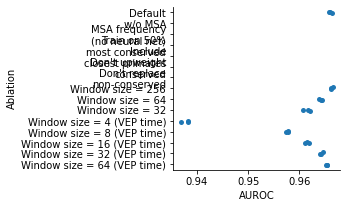

In [14]:
plt.figure(figsize=(3,3))
g = sns.stripplot(
    data=results_clinvar2,
    y="Ablation",
    x="AUROC",
    order=hparam_name.values(),
)
sns.despine()

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


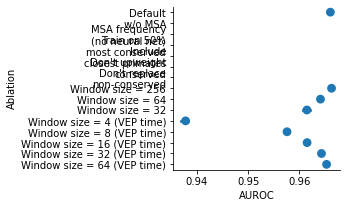

In [15]:
plt.figure(figsize=(3,3))
g = sns.pointplot(
    data=results_clinvar2,
    y="Ablation",
    x="AUROC",
    order=hparam_name.values(),
    join=False,
)
sns.despine()

## gnomAD rare vs. common

In [16]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    #df.loc[df[model_name] > df[model_name].quantile(0.1), "ModelScoreTier"] = "High"
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    return _compute_odds_ratio(df)

def _compute_odds_ratio(df):
    group_counts = df.groupby(["label", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [17]:
# TODO: should maybe make a lineplot with different thresholds
tq = 1e-3

rows = []
df_c = V[V.source=="gnomAD"]
df_c = df_c[df_c.AC != df_c.AN - 1]
df_c = df_c.dropna(subset=models + ["phyloP", "CADD", "phyloP-Zoonomia", "phastCons"])
for m in tqdm(models):
    subtitle = get_subtitle("All", (df_c.label=="Rare").sum(), (df_c.label=="Common").sum())
    OR, p_value, min_counts, cil, ciu = compute_odds_ratio(df_c[[m, "label"]], tq, m)
    rows.append([m, OR, p_value, min_counts, cil, ciu, subtitle])
results_gnomad = pd.DataFrame(rows, columns=["Model", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "subtitle"])
results_gnomad

  0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_367243/2750594759.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low"
/tmp/ipykernel_367243/2750594759.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = df.groupby(["label", "ModelScoreTier"]).size()
  4%|▎         | 1/27 [00:04<01:48,  4.16s/it]/tmp/ipykernel_367243/2750594759.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[d

,Model,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,38.350315,0.0,245,33.694110,43.649963,All\nn=4812825 vs. 4811795
1,multiz100way/89/128/64/True/defined.phastCons....,35.517883,0.0,264,31.350007,40.239863,All\nn=4812825 vs. 4811795
2,multiz100way/89/128/64/True/defined.phastCons....,37.105859,0.0,253,32.666287,42.148800,All\nn=4812825 vs. 4811795
3,multiz100way/89/32/16/True/defined.phastCons.p...,31.472020,0.0,298,27.977641,35.402843,All\nn=4812825 vs. 4811795
4,multiz100way/89/32/16/True/defined.phastCons.p...,27.881299,0.0,334,24.942300,31.166606,All\nn=4812825 vs. 4811795
5,multiz100way/89/32/16/True/defined.phastCons.p...,32.312581,0.0,290,28.679976,36.405292,All\nn=4812825 vs. 4811795
6,multiz100way/89/64/32/True/defined.phastCons.p...,35.444442,0.0,265,31.292449,40.147337,All\nn=4812825 vs. 4811795
7,multiz100way/89/64/32/True/defined.phastCons.p...,33.076417,0.0,283,29.316170,37.318973,All\nn=4812825 vs. 4811795
8,multiz100way/89/64/32/True/defined.phastCons.p...,34.788028,0.0,270,30.747556,39.359448,All\nn=4812825 vs. 4811795
9,multiz100way/89/256/128/True/defined.phastCons...,36.659241,0.0,256,32.296624,41.611158,All\nn=4812825 vs. 4811795


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


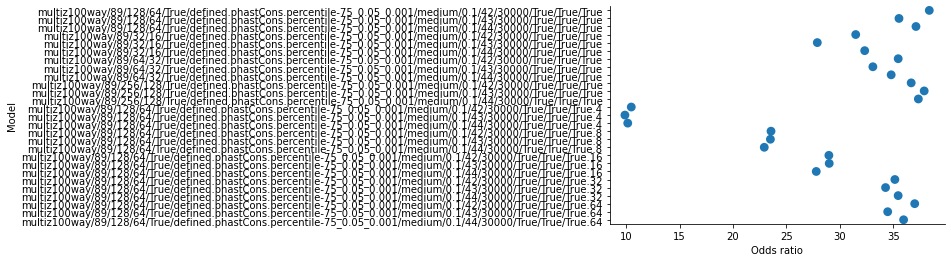

In [18]:
sns.pointplot(data=results_gnomad, y="Model", x="Odds ratio", join=False)
sns.despine();

In [19]:
results_gnomad["Ablation"] = None
for k, v in hparam_name.items():
    results_gnomad.loc[results_gnomad.Model.str.match(k), "Ablation"] = v
results_gnomad2 = results_gnomad.dropna()
results_gnomad2.Ablation.value_counts()

Ablation
Default                        3
Window size = 32               3
Window size = 64               3
Window size = 256              3
Window size = 4 (VEP time)     3
Window size = 8 (VEP time)     3
Window size = 16 (VEP time)    3
Window size = 32 (VEP time)    3
Window size = 64 (VEP time)    3
Name: count, dtype: int64

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

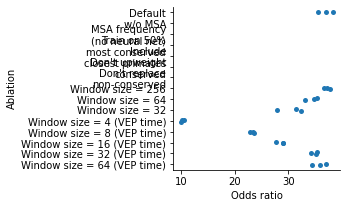

In [20]:
plt.figure(figsize=(3,3))
g = sns.stripplot(
    data=results_gnomad2,
    y="Ablation",
    x="Odds ratio",
    order=hparam_name.values(),
)
sns.despine()

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


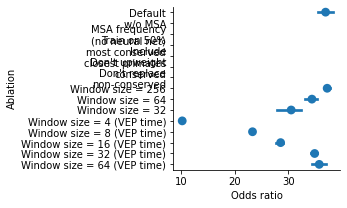

In [21]:
plt.figure(figsize=(3,3))
g = sns.pointplot(
    data=results_gnomad2,
    y="Ablation",
    x="Odds ratio",
    order=hparam_name.values(),
    join=False,
)
sns.despine()

## Merged

In [22]:
merged_res = results_clinvar2.merge(results_gnomad2, how="inner", on=["Model", "Ablation"])
merged_res

,Model,AUROC,AUPRC,Ablation,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555,Default,38.350315,0.0,245,33.694110,43.649963,All\nn=4812825 vs. 4811795
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538,Default,35.517883,0.0,264,31.350007,40.239863,All\nn=4812825 vs. 4811795
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794,Default,37.105859,0.0,253,32.666287,42.148800,All\nn=4812825 vs. 4811795
3,multiz100way/89/32/16/True/defined.phastCons.p...,0.962005,0.974270,Window size = 32,31.472020,0.0,298,27.977641,35.402843,All\nn=4812825 vs. 4811795
4,multiz100way/89/32/16/True/defined.phastCons.p...,0.960693,0.973070,Window size = 32,27.881299,0.0,334,24.942300,31.166606,All\nn=4812825 vs. 4811795
5,multiz100way/89/32/16/True/defined.phastCons.p...,0.961780,0.974203,Window size = 32,32.312581,0.0,290,28.679976,36.405292,All\nn=4812825 vs. 4811795
6,multiz100way/89/64/32/True/defined.phastCons.p...,0.964389,0.976353,Window size = 64,35.444442,0.0,265,31.292449,40.147337,All\nn=4812825 vs. 4811795
7,multiz100way/89/64/32/True/defined.phastCons.p...,0.963852,0.975766,Window size = 64,33.076417,0.0,283,29.316170,37.318973,All\nn=4812825 vs. 4811795
8,multiz100way/89/64/32/True/defined.phastCons.p...,0.964204,0.975979,Window size = 64,34.788028,0.0,270,30.747556,39.359448,All\nn=4812825 vs. 4811795
9,multiz100way/89/256/128/True/defined.phastCons...,0.966573,0.977901,Window size = 256,36.659241,0.0,256,32.296624,41.611158,All\nn=4812825 vs. 4811795


In [23]:
markers = {}
for hparam in hparam_name.values():
    markers[hparam] = 'X' if hparam == "MSA frequency\n(no neural net)" else 'o'

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

Text(0, 0.5, 'gnomAD odds ratio')

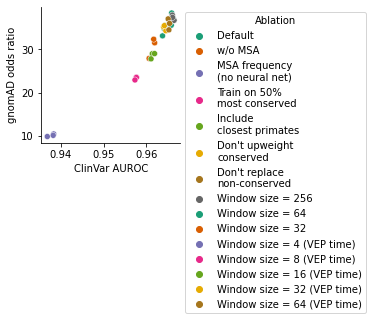

In [24]:
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res,
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    style="Ablation", markers=markers,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.xlabel("ClinVar AUROC")
plt.ylabel("gnomAD odds ratio")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

Text(0, 0.5, 'gnomAD odds ratio')

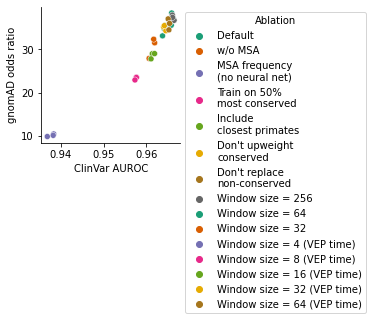

In [25]:
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res[merged_res.Ablation != "w/o MSA"],
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    style="Ablation", markers=markers,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.xlabel("ClinVar AUROC")
plt.ylabel("gnomAD odds ratio")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

Text(0, 0.5, 'gnomAD odds ratio')

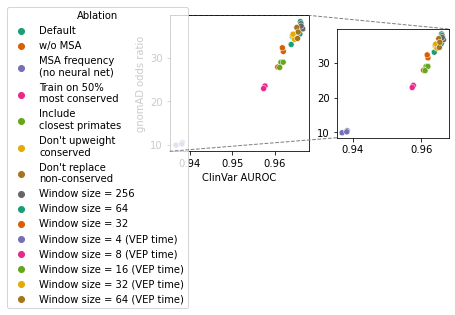

In [26]:
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res,
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    style="Ablation", markers=markers,
)
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(-1.2, 1.1))


#axins = inset_axes(g, width='60%', height='60%', loc='center')

axins = inset_axes(g, 
                   width='100%',  # Width of the inset plot (as a percentage of the main plot)
                   height='100%',  # Height of the inset plot
                   loc='center', 
                   bbox_to_anchor=(1.2, 0.1, 0.8, 0.8),  # (x, y, width, height) relative to the size and position of the main plot
                   bbox_transform=g.transAxes,  # Coordinate system transformation
                   borderpad=0)  # Optional padding around the inset plot


sns.scatterplot(
    data=merged_res[merged_res.Ablation != "w/o MSA"],
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    legend=False,
    ax=axins,
    style="Ablation", markers=markers,
)

# doesn't look good
#x1, x2 = axins.get_xlim()
#y1, y2 = axins.get_ylim()
#axins.set_xlim(x1-1e-2, x2+1e-2)
#axins.set_ylim(y1, y2)

axins.set_xlabel("")
axins.set_ylabel("")
mark_inset(g, axins, loc1=3, loc2=1, fc="none", ec="0.5", linestyle="--")
g.set_xlabel("ClinVar AUROC")
g.set_ylabel("gnomAD odds ratio")
#plt.savefig(plot_dir + "ablation.pdf", bbox_inches="tight")

In [27]:
axins.get_ylim()

(8.472979036983716, 39.77304522643074)

In [28]:
#merged_res_avg = merged_res.groupby("Ablation").agg({"AUROC": "mean", "Odds ratio": "mean"}).reset_index()
#merged_res_avg

In [29]:
"""
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res_avg,
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
)
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(-1.2, 1.05))


#axins = inset_axes(g, width='60%', height='60%', loc='center')

axins = inset_axes(g, 
                   width='100%',  # Width of the inset plot (as a percentage of the main plot)
                   height='100%',  # Height of the inset plot
                   loc='center', 
                   bbox_to_anchor=(1.2, 0.1, 0.8, 0.8),  # (x, y, width, height) relative to the size and position of the main plot
                   bbox_transform=g.transAxes,  # Coordinate system transformation
                   borderpad=0)  # Optional padding around the inset plot


sns.scatterplot(
    data=merged_res_avg[merged_res_avg.Ablation != "w/o MSA"],
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    legend=False,
    ax=axins,
)
axins.set_xlabel("")
axins.set_ylabel("")
mark_inset(g, axins, loc1=3, loc2=1, fc="none", ec="0.5", linestyle="--")
g.set_xlabel("ClinVar AUROC")
g.set_ylabel("gnomAD odds ratio")
#plt.savefig(plot_dir + "ablation.svg", bbox_inches="tight")
""";

## Reducing window size

In [35]:
df = merged_res.copy()
df.Ablation.replace("Default", "Window size = 128 (VEP time)", inplace=True)
df = df[df.Ablation.str.contains("VEP time")]
df["Window size"] = df.Ablation.str.split().str[3].astype(int)
df

,Model,AUROC,AUPRC,Ablation,Odds ratio,p_value,min_counts,cil,ciu,subtitle,Window size
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555,Window size = 128 (VEP time),38.350315,0.0,245,33.694110,43.649963,All\nn=4812825 vs. 4811795,128
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538,Window size = 128 (VEP time),35.517883,0.0,264,31.350007,40.239863,All\nn=4812825 vs. 4811795,128
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794,Window size = 128 (VEP time),37.105859,0.0,253,32.666287,42.148800,All\nn=4812825 vs. 4811795,128
12,multiz100way/89/128/64/True/defined.phastCons....,0.938297,0.953079,Window size = 4 (VEP time),10.490310,0.0,844,9.760918,11.274206,All\nn=4812825 vs. 4811795,4
13,multiz100way/89/128/64/True/defined.phastCons....,0.936796,0.950958,Window size = 4 (VEP time),9.895709,0.0,887,9.222259,10.618338,All\nn=4812825 vs. 4811795,4
14,multiz100way/89/128/64/True/defined.phastCons....,0.938173,0.951886,Window size = 4 (VEP time),10.159750,0.0,868,9.461876,10.909096,All\nn=4812825 vs. 4811795,4
15,multiz100way/89/128/64/True/defined.phastCons....,0.957736,0.969280,Window size = 8 (VEP time),23.553613,0.0,394,21.250756,26.106021,All\nn=4812825 vs. 4811795,8
16,multiz100way/89/128/64/True/defined.phastCons....,0.957702,0.968806,Window size = 8 (VEP time),23.497577,0.0,394,21.200093,26.044042,All\nn=4812825 vs. 4811795,8
17,multiz100way/89/128/64/True/defined.phastCons....,0.957378,0.968270,Window size = 8 (VEP time),22.922970,0.0,403,20.704496,25.379153,All\nn=4812825 vs. 4811795,8
18,multiz100way/89/128/64/True/defined.phastCons....,0.961446,0.973049,Window size = 16 (VEP time),28.964061,0.0,322,25.859601,32.441212,All\nn=4812825 vs. 4811795,16


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


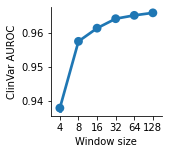

In [41]:
plt.figure(figsize=(2,2))
sns.pointplot(data=df, x="Window size", y="AUROC", errorbar="sd")
plt.ylabel("ClinVar AUROC")
sns.despine();

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


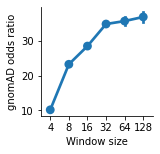

In [42]:
plt.figure(figsize=(2,2))
sns.pointplot(data=df, x="Window size", y="Odds ratio", errorbar="sd")
plt.ylabel("gnomAD odds ratio")
sns.despine();

## Increasing window size

In [44]:
df = merged_res.copy()
df.Ablation.replace("Default", "Window size = 128", inplace=True)
df = df[df.Ablation.str.contains("Window size") & ~df.Ablation.str.contains("VEP time")]
df["Window size"] = df.Ablation.str.split().str[3].astype(int)
df = df[df["Window size"].isin([128, 256])]
df

,Model,AUROC,AUPRC,Ablation,Odds ratio,p_value,min_counts,cil,ciu,subtitle,Window size
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555,Window size = 128,38.350315,0.0,245,33.694110,43.649963,All\nn=4812825 vs. 4811795,128
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538,Window size = 128,35.517883,0.0,264,31.350007,40.239863,All\nn=4812825 vs. 4811795,128
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794,Window size = 128,37.105859,0.0,253,32.666287,42.148800,All\nn=4812825 vs. 4811795,128
9,multiz100way/89/256/128/True/defined.phastCons...,0.966573,0.977901,Window size = 256,36.659241,0.0,256,32.296624,41.611158,All\nn=4812825 vs. 4811795,256
10,multiz100way/89/256/128/True/defined.phastCons...,0.966161,0.977664,Window size = 256,37.874235,0.0,248,33.301286,43.075145,All\nn=4812825 vs. 4811795,256
11,multiz100way/89/256/128/True/defined.phastCons...,0.966203,0.977623,Window size = 256,37.328784,0.0,252,32.854570,42.412308,All\nn=4812825 vs. 4811795,256


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


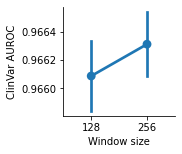

In [45]:
plt.figure(figsize=(2,2))
sns.pointplot(data=df, x="Window size", y="AUROC", errorbar="sd")
plt.ylabel("ClinVar AUROC")
sns.despine();

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


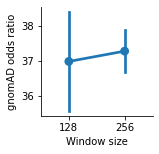

In [46]:
plt.figure(figsize=(2,2))
sns.pointplot(data=df, x="Window size", y="Odds ratio", errorbar="sd")
plt.ylabel("gnomAD odds ratio")
sns.despine();